In [7]:
#importing the required libraries
import pandas as pd
import numpy as np

In [8]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

In [9]:
from datetime import datetime
from pandas import Series

In [10]:
#reading the training data
train = pd.read_csv(r"/home/chaitanya/Downloads/ProjectData/Train_SU63ISt.csv")

In [11]:
#reading the testing data
test = pd.read_csv(r"/home/chaitanya/Downloads/ProjectData/Test_0qrQsBZ.csv")

In [12]:
#creating copy of training and testing data
train_original=train.copy()
test_original=test.copy()

In [13]:
#analyzing the dataset structure and contents
print(test.columns)
print(train.columns)

Index(['ID', 'Datetime'], dtype='object')
Index(['ID', 'Datetime', 'Count'], dtype='object')


In [14]:
print(test.dtypes)
print(train.dtypes)

ID           int64
Datetime    object
dtype: object
ID           int64
Datetime    object
Count        int64
dtype: object


In [15]:
print(test.shape)
print(train.shape)

(5112, 2)
(18288, 3)


In [16]:
# extracting features
# converting Datetime to datetime format
train['Datetime']=pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M')
test['Datetime']=pd.to_datetime(test.Datetime,format='%d-%m-%Y %H:%M')

In [17]:
train_original['Datetime']=pd.to_datetime(train_original.Datetime,format='%d-%m-%Y %H:%M')
test_original['Datetime']=pd.to_datetime(test_original.Datetime,format='%d-%m-%Y %H:%M')

In [18]:
# extracting year, month, day and Hour from the data
for i in (train, test, test_original, train_original):
    i['year']=i.Datetime.dt.year
    i['month']=i.Datetime.dt.month
    i['day']=i.Datetime.dt.day
    i['Hour']=i.Datetime.dt.hour
    

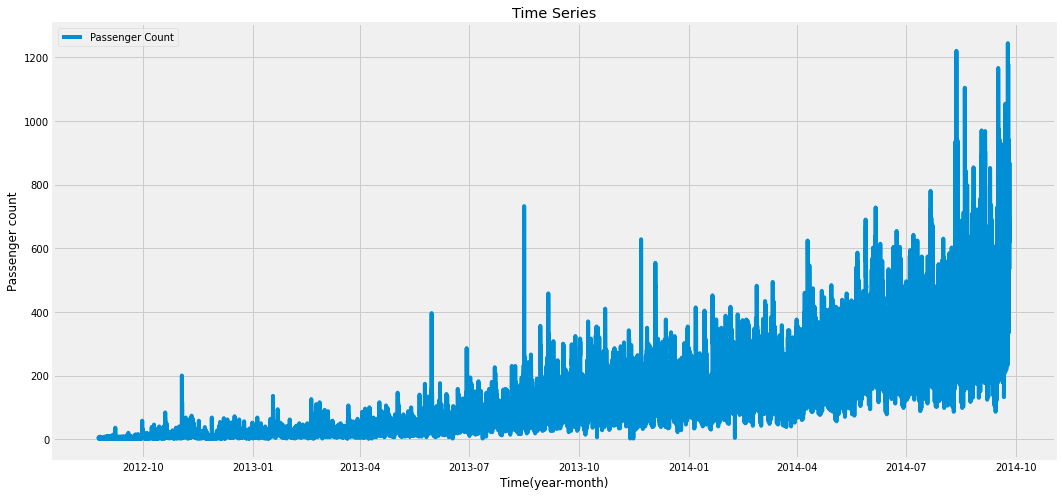

In [19]:
# assigning Datetime as index for the data and visualizing the data using Time and Count
train.index=train['Datetime']
df=train.drop('ID',1)
ts=df['Count']
plt.figure(figsize=(16,8))
plt.plot(ts,label='Passenger Count')
plt.title('Time Series')
plt.xlabel('Time(year-month)')
plt.ylabel("Passenger count")
plt.legend(loc='best')

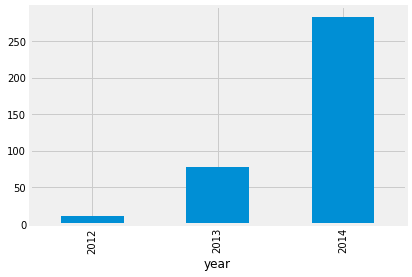

In [20]:
#visualizing yearly data
train.groupby('year')['Count'].mean().plot.bar()

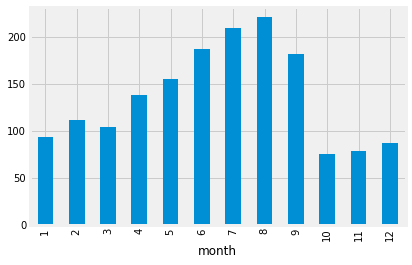

In [21]:
#visualizing monthly data
train.groupby('month')['Count'].mean().plot.bar()

In [22]:
#Converting to Hourly mean 
hourly=train.resample('H').mean()
#Converting to Daily mean 
daily=train.resample('D').mean()
#Converting to Weekly mean 
weekly=train.resample('W').mean()
#Converting to Monthly mean 
monthly=train.resample('M').mean()

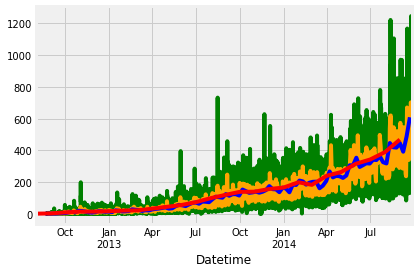

In [23]:
#visualizing the hourly, daily, weekly and monthly data
hourly.Count.plot(color='green')
daily.Count.plot(color='orange')
weekly.Count.plot(color='blue')
monthly.Count.plot(color='red')

In [24]:
#splitting the train data into train and valid data
Train=train.Datetime['2012-08-25':'2014-06-24']
valid=train.Datetime['2014-06-25':'2014-09-25']

In [25]:
# applying Dickey-Fuller test before using ARIMA model for time series forecasting
from statsmodels.tsa.stattools import adfuller
def test_stationary(timeseries):
    #Determine rolling statistics
    rolmean = timeseries.rolling(24).mean()
    rolstd = timeseries.rolling(24).std()
    
    #Plot rolling Statistics
    orig = plt.plot(timeseries, color = "blue", label = "Original")
    mean = plt.plot(rolmean, color = "red", label = "Rolling Mean")
    std = plt.plot(rolstd, color = "black", label = "Rolling Std")
    plt.legend(loc = "best")
    plt.title("Rolling Mean and Standard Deviation")
    plt.show(block = False)
    
    #Perform Dickey Fuller test
    print("Results of Dickey Fuller test: ")
    dftest = adfuller(timeseries, autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistics', 'p-value', '# Lag Used', 'Number of Observations Used'])
    
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    print(dfoutput)


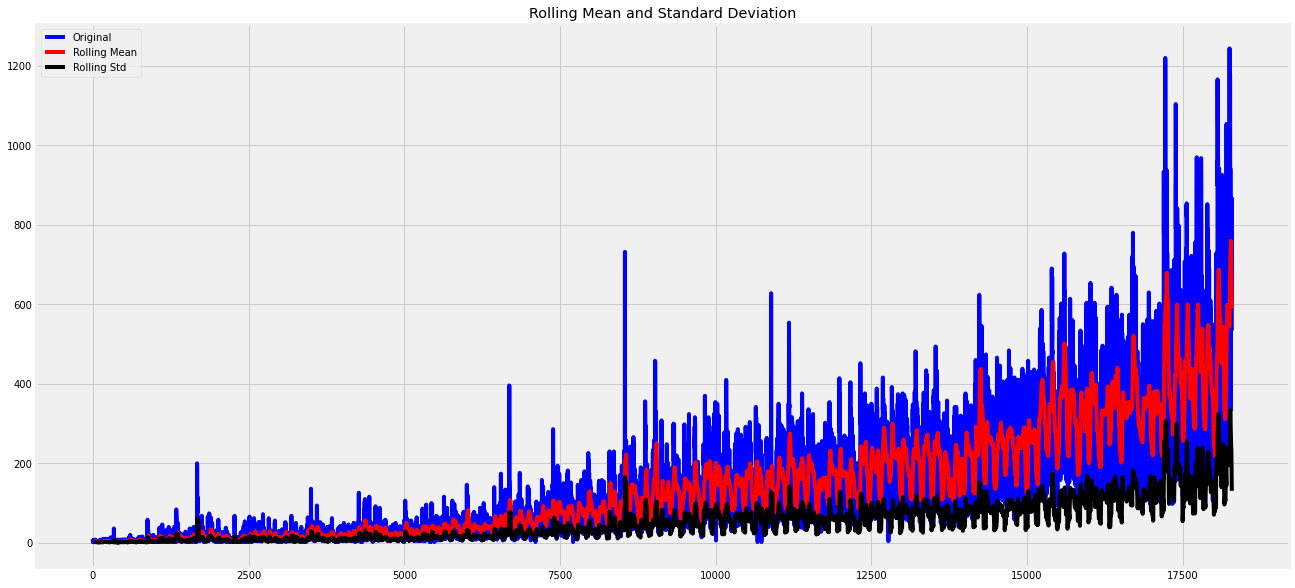

Results of Dickey Fuller test: 
Test Statistics                   -4.456561
p-value                            0.000235
# Lag Used                        45.000000
Number of Observations Used    18242.000000
Critical Value (1%)               -3.430709
Critical Value (5%)               -2.861698
Critical Value (10%)              -2.566854
dtype: float64


In [26]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=(20,10)
test_stationary(train_original['Count'])

In [27]:
# removing trends from the data to increase stability in data
Train_log = np.log(df['Count'])
valid_log = np.log(df['Count'])
moving_avg = Train_log.rolling(24).mean()

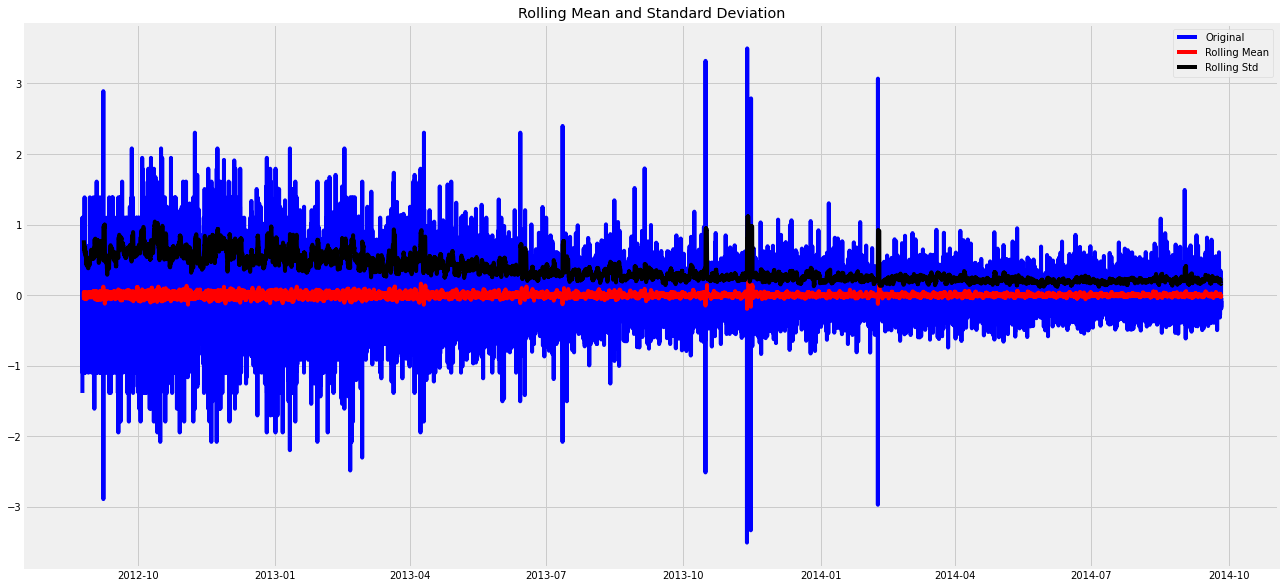

Results of Dickey Fuller test: 
Test Statistics                  -32.041628
p-value                            0.000000
# Lag Used                        45.000000
Number of Observations Used    18241.000000
Critical Value (1%)               -3.430709
Critical Value (5%)               -2.861698
Critical Value (10%)              -2.566854
dtype: float64


In [28]:
#performing differencing to make the series stable and eliminate trends
train_log_diff = Train_log - Train_log.shift(1)
test_stationary(train_log_diff.dropna())


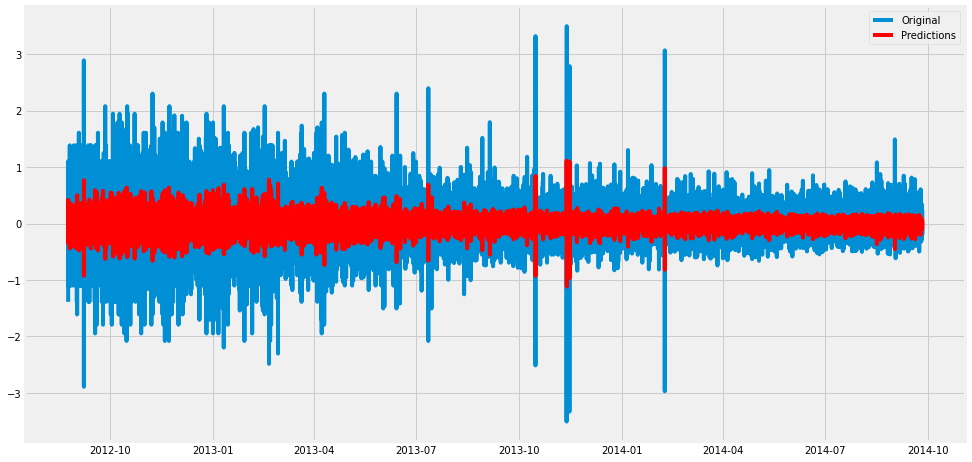

In [29]:
# predicitng timeseries using ARIMA model
from statsmodels.tsa.arima_model import ARIMA
plt.figure(figsize = (15,8))
model = ARIMA(Train_log, order = (2,1,0))  #here q value is zero since it is just AR Model
results_AR = model.fit(disp=-1)
plt.plot(train_log_diff.dropna(), label = "Original")
plt.plot(results_AR.fittedvalues, color = 'red', label = 'Predictions')
plt.legend(loc = 'best')
